In [1]:
import sys
sys.path.append("/home/oldrain123/IMBALANCED_CLASSIFICATION/MOMs")

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from imblearn.metrics import geometric_mean_score
from moms_losses import MMD_est_torch

In [3]:
# seed 고정
def set_random_seed(seed=1203):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [4]:
# 시각화 설정
plt.rc("text", usetex=False)
plt.rc("font", family="serif", size=12)
plt.rcParams["figure.dpi"] = 150

# seed 설정
seed = 1203

In [5]:
def generate_overlapping_classification(n_samples=1000, class_sep=0.5, random_state=1203):
    X, y = make_classification(n_samples=n_samples, n_features=2, n_informative=2,
                               n_redundant=0, n_clusters_per_class=2, weights=[0.5, 0.5],
                               flip_y=0, class_sep=class_sep, random_state=random_state)
    return X, y

In [6]:
def generate_imb_data(X, y, minor_y_cnt, seed=1203):
    """원본 데이터를 불균형하게 만드는 함수"""
    set_random_seed(seed)
    idx_minor = np.where(y == 0)[0]
    idx_major = np.where(y == 1)[0]
    if len(idx_minor) > minor_y_cnt:
        np.random.shuffle(idx_minor)
        idx_minor = idx_minor[:minor_y_cnt]
    idx_imb = np.concatenate((idx_minor, idx_major))
    X_imb = X[idx_imb]
    y_imb = y[idx_imb]
    return X_imb, y_imb

In [7]:
# balanced dataset : 소수 클래스 500개, 다수 클래스 500개
X_cls_bal, y_cls_bal = make_classification(n_samples=1000, n_features=2, n_informative=2, 
                                           n_redundant=0, n_clusters_per_class=2, 
                                           weights=[0.5, 0.5], flip_y=0.01, class_sep=0.6, random_state=seed)

# imbalanced dataset: 소수 클래스 50개, 다수 클래스 그대로 (대략 500개)
X_cls_imb, y_cls_imb = generate_imb_data(X_cls_bal, y_cls_bal, minor_y_cnt=50, seed=seed)

In [8]:
# ================================
# 2. half-moons 데이터
# ================================
# balanced
X_moons_bal, y_moons_bal = make_moons(n_samples=1000, noise=0.25, random_state=seed)

# imbalanced: 소수 클래스 50개 (여기서는 클래스 0를 소수 클래스로 가정)
X_moons_imb, y_moons_imb = generate_imb_data(X_moons_bal, y_moons_bal, minor_y_cnt=50, seed=seed)

In [9]:
# ================================
# 3. circles 데이터
# ================================
# balanced
X_circ_bal, y_circ_bal = make_circles(n_samples=1000, noise=0.15, factor=0.6, random_state=seed)

# imbalanced: 소수 클래스 50개 (여기서도 클래스 0를 소수 클래스로 가정)
X_circ_imb, y_circ_imb = generate_imb_data(X_circ_bal, y_circ_bal, minor_y_cnt=50, seed=seed)

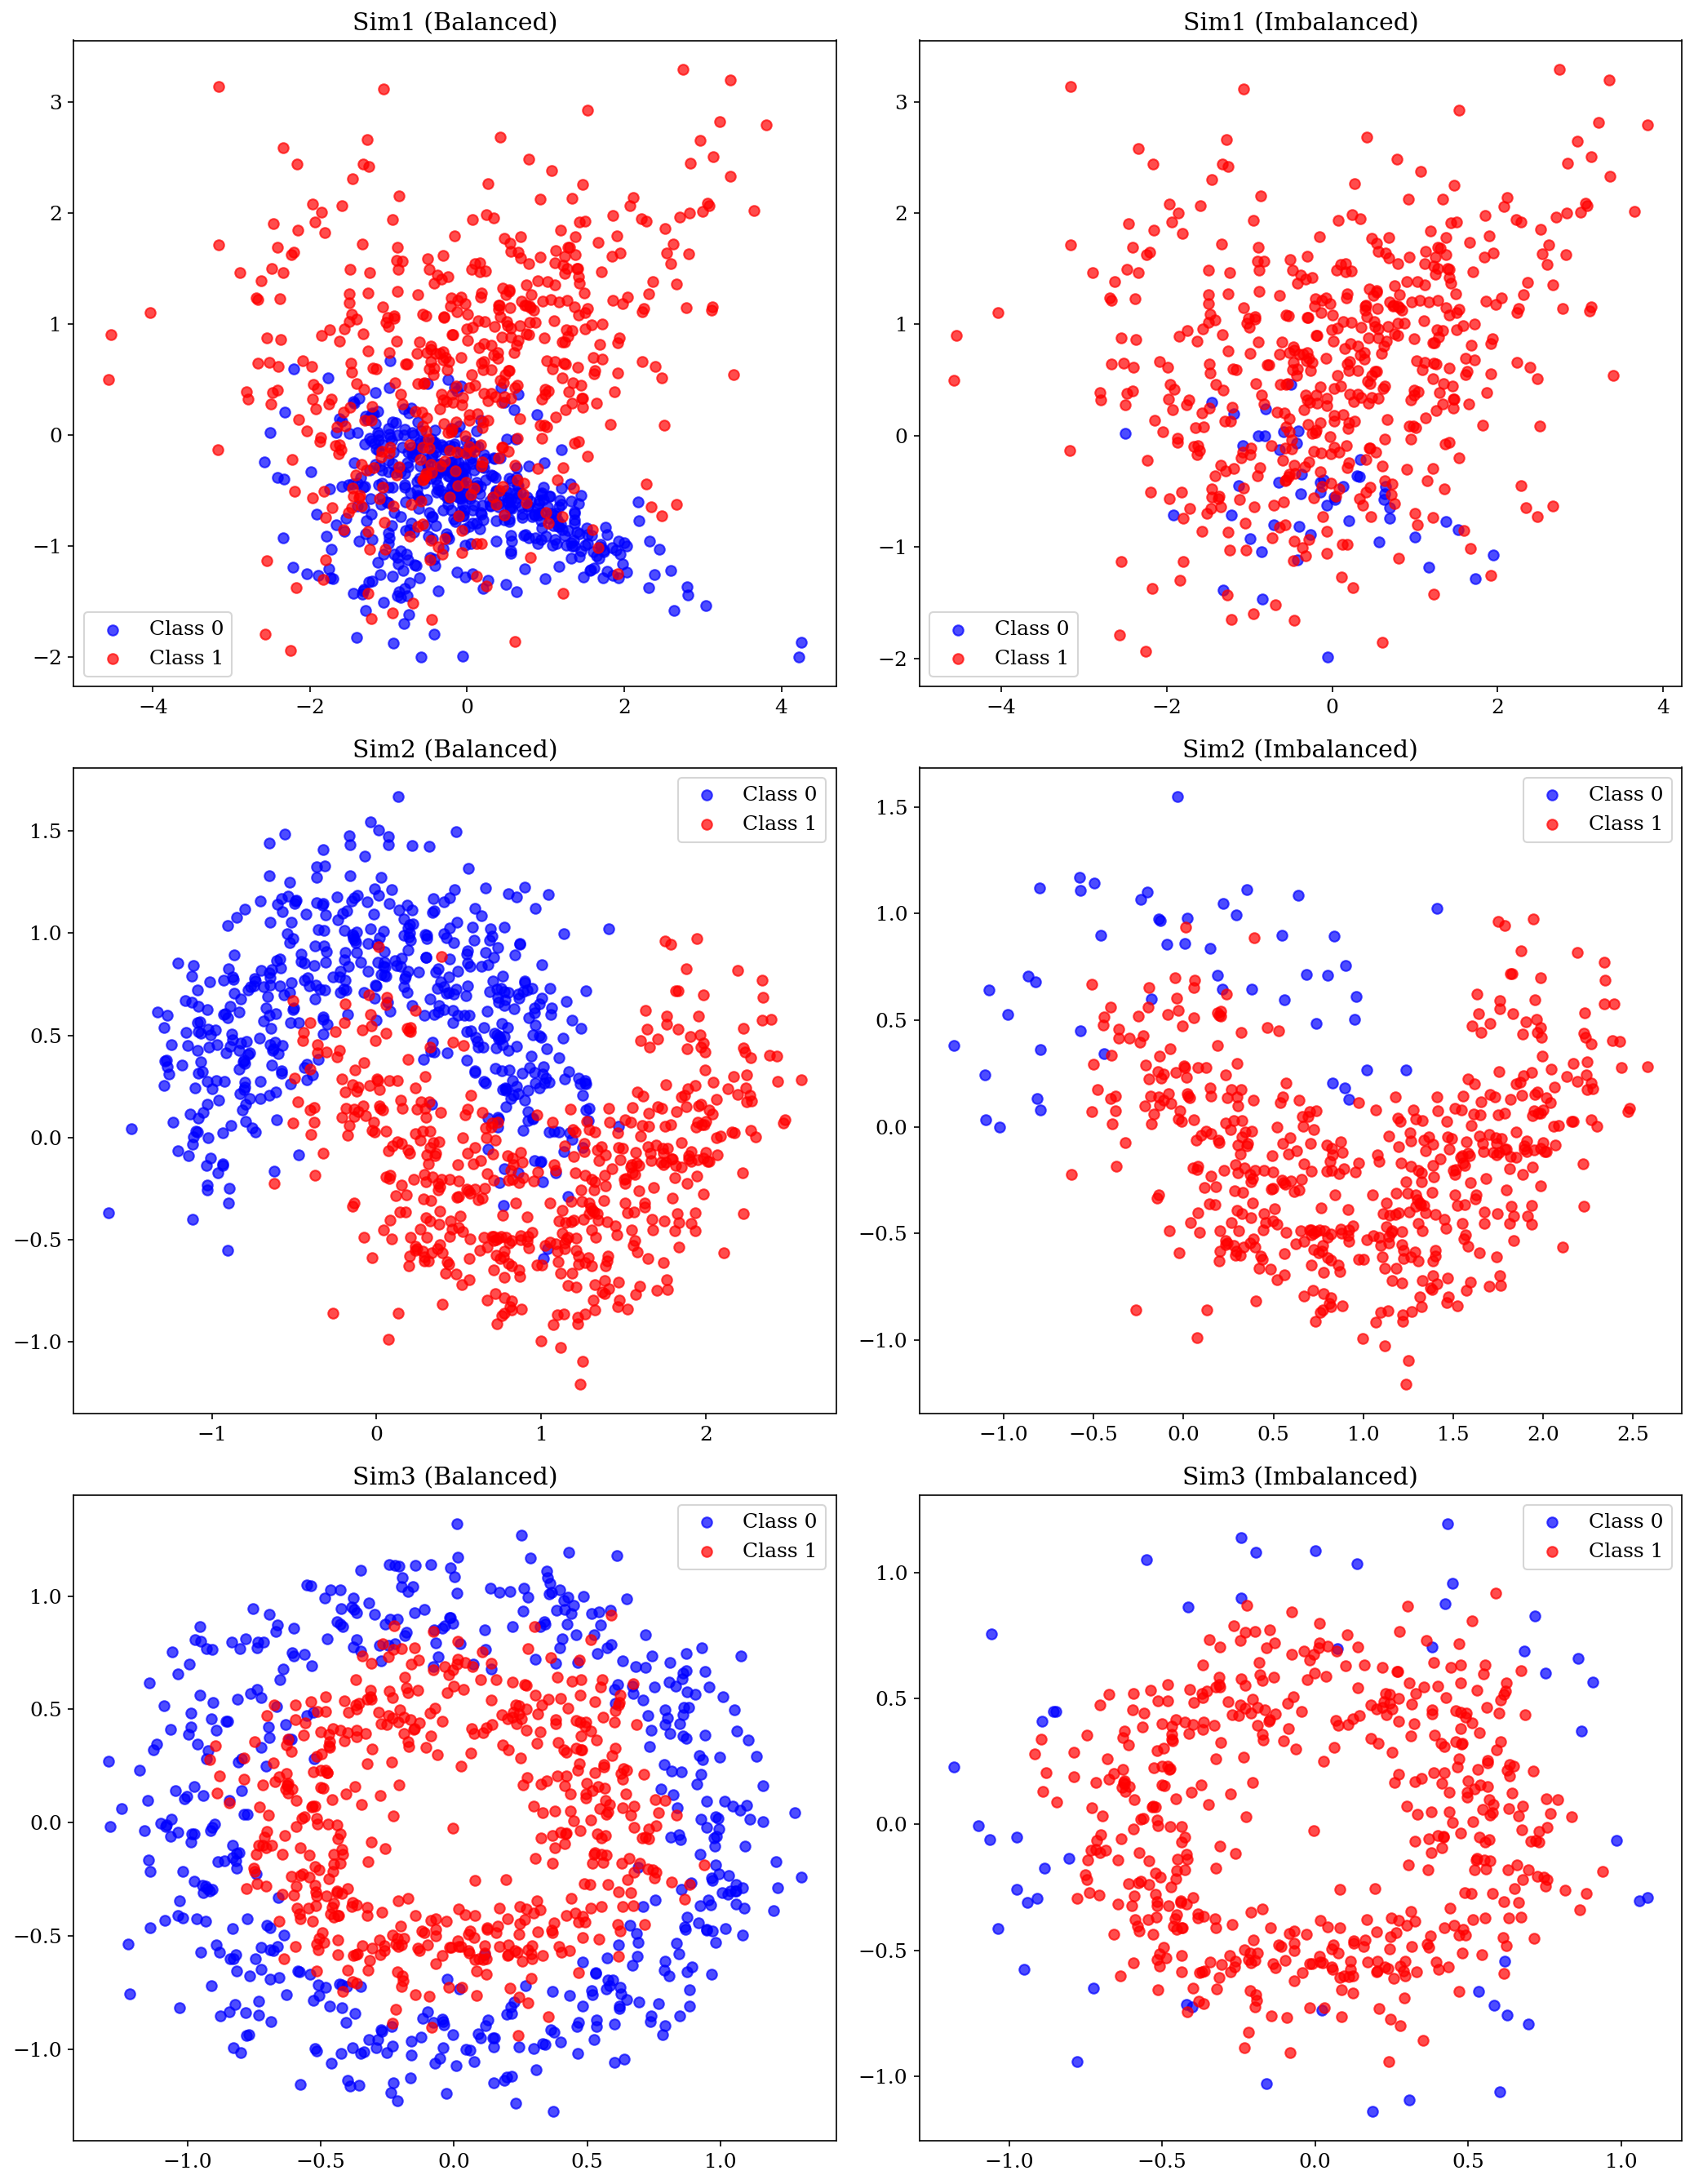

In [10]:
# ================================
# 시각화 balanced & imbalanced
# ================================
fig, axs = plt.subplots(3, 2, figsize=(14, 18))

# [1] make_classification
# Balanced
axs[0,0].scatter(X_cls_bal[y_cls_bal==0, 0], X_cls_bal[y_cls_bal==0, 1], c='blue', alpha=0.7, label='Class 0')
axs[0,0].scatter(X_cls_bal[y_cls_bal==1, 0], X_cls_bal[y_cls_bal==1, 1], c='red', alpha=0.7, label='Class 1')
axs[0,0].set_title("Sim1 (Balanced)")
axs[0,0].legend()
# Imbalanced
axs[0,1].scatter(X_cls_imb[y_cls_imb==0, 0], X_cls_imb[y_cls_imb==0, 1], c='blue', alpha=0.7, label='Class 0')
axs[0,1].scatter(X_cls_imb[y_cls_imb==1, 0], X_cls_imb[y_cls_imb==1, 1], c='red', alpha=0.7, label='Class 1')
axs[0,1].set_title("Sim1 (Imbalanced)")
axs[0,1].legend()

# [2] make_moons
# Balanced
axs[1,0].scatter(X_moons_bal[y_moons_bal==0, 0], X_moons_bal[y_moons_bal==0, 1], c='blue', alpha=0.7, label='Class 0')
axs[1,0].scatter(X_moons_bal[y_moons_bal==1, 0], X_moons_bal[y_moons_bal==1, 1], c='red', alpha=0.7, label='Class 1')
axs[1,0].set_title("Sim2 (Balanced)")
axs[1,0].legend()
# Imbalanced
axs[1,1].scatter(X_moons_imb[y_moons_imb==0, 0], X_moons_imb[y_moons_imb==0, 1], c='blue',  alpha=0.7,label='Class 0')
axs[1,1].scatter(X_moons_imb[y_moons_imb==1, 0], X_moons_imb[y_moons_imb==1, 1], c='red',  alpha=0.7,label='Class 1')
axs[1,1].set_title("Sim2 (Imbalanced)")
axs[1,1].legend()

# [3] make_circles
# Balanced
axs[2,0].scatter(X_circ_bal[y_circ_bal==0, 0], X_circ_bal[y_circ_bal==0, 1], c='blue',  alpha=0.7,label='Class 0')
axs[2,0].scatter(X_circ_bal[y_circ_bal==1, 0], X_circ_bal[y_circ_bal==1, 1], c='red',  alpha=0.7,label='Class 1')
axs[2,0].set_title("Sim3 (Balanced)")
axs[2,0].legend()
# Imbalanced
axs[2,1].scatter(X_circ_imb[y_circ_imb==0, 0], X_circ_imb[y_circ_imb==0, 1], c='blue', alpha=0.7, label='Class 0')
axs[2,1].scatter(X_circ_imb[y_circ_imb==1, 0], X_circ_imb[y_circ_imb==1, 1], c='red', alpha=0.7, label='Class 1')
axs[2,1].set_title("Sim3 (Imbalanced)")
axs[2,1].legend()

plt.tight_layout()
plt.show()

In [11]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        output = self.decoder(latent)
        return output

In [12]:
def compute_danger_set(X_minor, X_major, seed, k=5):
    set_random_seed(seed)
    from sklearn.neighbors import NearestNeighbors
    X_minor_np = X_minor.detach().cpu().numpy()
    X_all = torch.cat([X_minor, X_major], dim=0)
    X_all_np = X_all.detach().cpu().numpy()
    
    nn = NearestNeighbors(n_neighbors=k+1, algorithm='auto', n_jobs=-1)
    nn.fit(X_all_np)
    _, nn_idx = nn.kneighbors(X_minor_np)
    nn_idx = torch.tensor(nn_idx, device=X_minor.device)[:, 1:]

    maj_mask = nn_idx >= X_minor.shape[0]
    maj_cnt = maj_mask.sum(dim=1)

    danger_mask = maj_cnt > int(k * 0.3)
    all_maj_mask = maj_mask.all(dim=1)

    danger_set = X_minor[danger_mask & ~all_maj_mask]
    return danger_set

In [13]:
def triplet_loss(X_minor, X_trans, X_major, k=5, alpha=0.1):
    n = X_trans.size(0)

    pos_dist = torch.cdist(X_trans, X_minor, p=2)**2  
    neg_dist = torch.cdist(X_trans, X_major, p=2)**2  
    pos_values, _ = pos_dist.topk(k=k, largest=False, dim=1)
    neg_values, _ = neg_dist.topk(k=k, largest=False, dim=1)

    pull_loss = pos_values.max(dim=1)[0]
    push_loss = neg_values.min(dim=1)[0]

    margin = torch.abs(pull_loss - push_loss) / (n - 1 + 1e-8)
    loss = torch.relu(pull_loss - alpha * push_loss + margin).mean()
    return loss

In [14]:
def adaptive_kernel_width(X, Y=None):
    if Y is None:
        Y = X
    if isinstance(X, torch.Tensor) or isinstance(Y, torch.Tensor):
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, dtype=torch.float32)
        if not isinstance(Y, torch.Tensor):
            Y = torch.tensor(Y, dtype=torch.float32)
        
        dists = torch.cdist(X, Y, p=2)
        bandwidth = torch.median(dists)
        return bandwidth
    else:
        dists = np.linalg.norm(X[:, None, :] - Y[None, :, :], axis=2)
        bandwidth = np.median(dists)
        return bandwidth

In [15]:
def train_autoencoder(autoencoder, major_loader, minor_loader, device,
                      num_epochs=2000, lr=1e-3, beta=0.0, k=5, seed=1203):
    
    set_random_seed(seed)
    optimizer = optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=1e-4)
    autoencoder.to(device)
    
    for epoch in range(num_epochs):
        autoencoder.train()
        total_loss = 0.0
        for major_batch, minor_batch in zip(major_loader, minor_loader):
            X_major = major_batch[0].to(device)
            X_minor = minor_batch[0].to(device)
            optimizer.zero_grad()
            X_trans = autoencoder(X_major)
            bandwidth = adaptive_kernel_width(X_major, X_minor)
            mmd_loss = MMD_est_torch(X_trans, X_minor, kernel_type='gaussian', h=bandwidth)
            
            if beta > 0.0:
                danger_set_minor = compute_danger_set(X_minor, X_major, seed=seed, k=k)
                danger_set_major = compute_danger_set(X_major, X_minor, seed=seed, k=k)
                if danger_set_minor.shape[0] == 0 or danger_set_major.shape[0] == 0:
                    # print("No danger set found, beta=0.")
                    loss = mmd_loss
                    reg_loss = 0.0
                else:
                    reg_loss = triplet_loss(danger_set_minor, X_trans, danger_set_major, k=k, alpha=1.0)
                    loss = mmd_loss + beta * reg_loss
            else:
                loss = mmd_loss
                # loss = triplet_loss(X_minor, X_trans, )
            if not isinstance(reg_loss, torch.Tensor):
                reg_loss = torch.tensor(reg_loss, device=device)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(autoencoder.parameters(), max_norm=0.01)
            optimizer.step()
            total_loss += loss.item()

        if (epoch+1) % 500 == 0:
            avg_loss = total_loss / len(major_loader)
            avg_reg_loss = reg_loss.item() / len(major_loader) if beta > 0.0 else 0.0
            print(f"[Epoch {epoch+1}/{num_epochs}] Total Loss: {avg_loss:.4f}   |   MMD Loss: {mmd_loss.item():.4f}   |   Regularization Loss: {avg_reg_loss:.4f} (beta={beta})")
    
    return autoencoder

In [16]:
def run_experiment(sim_name, X_bal, y_bal, X_imbl, y_imbl):
    print(f"\nRunning experiment for {sim_name}")
    
    # imbalanced 데이터에서 minority와 majority 분리 (minority: label 0, majority: label 1)
    minority_idx = np.where(y_imbl == 0)[0]
    majority_idx = np.where(y_imbl == 1)[0]
    X_minority = X_imbl[minority_idx]
    X_majority = X_imbl[majority_idx]
    
    n_min = len(minority_idx)
    n_maj = len(majority_idx)
    n_trans = n_maj - n_min  # autoencoder에 사용할 majority 샘플 수
    print(f"n_minority: {n_min}, n_majority: {n_maj}, n_trans: {n_trans}")
    
    # majority 전체 중에서 n_trans 개를 랜덤 샘플링
    rand_indices = np.random.choice(n_maj, size=n_trans, replace=False)
    X_majority_trans = X_majority[rand_indices]
    
    # PyTorch tensor 변환 및 DataLoader 구성
    X_minority_tensor = torch.tensor(X_minority, dtype=torch.float32)
    X_majority_trans_tensor = torch.tensor(X_majority_trans, dtype=torch.float32)
    majority_dataset = TensorDataset(X_majority_trans_tensor)
    minority_dataset = TensorDataset(X_minority_tensor)
    majority_loader = DataLoader(majority_dataset, batch_size=len(majority_dataset), shuffle=True)
    minority_loader = DataLoader(minority_dataset, batch_size=len(minority_dataset), shuffle=True)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    autoencoder = Autoencoder(input_dim=2, latent_dim=32)
    trained_autoencoder = train_autoencoder(autoencoder, majority_loader, minority_loader,
                                            device, num_epochs=1000, lr=1e-3, beta=0.001)
    
    # 선택된 majority 샘플에 대해 transform 수행
    trained_autoencoder.eval()
    with torch.no_grad():
        transformed_majority = trained_autoencoder(X_majority_trans_tensor.to(device)).cpu().numpy()
    
    # Figure 생성: 좌측 - 원본 balanced 데이터, 우측 - imbalanced 데이터 결과
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # 좌측 subplot: balanced data (두 클래스 분포가 동일한 모양)
    axs[0].scatter(X_bal[y_bal == 0, 0], X_bal[y_bal == 0, 1],
                c='blue', marker='^', s=25, label='Minority (Class 0)')
    axs[0].scatter(X_bal[y_bal == 1, 0], X_bal[y_bal == 1, 1],
                c='red', marker='o', s=25, label='Majority (Class 1)')
    axs[0].set_title(f"{sim_name} (Balanced)", fontsize=14)
    axs[0].set_xlabel("Feature 1", fontsize=12)
    axs[0].set_ylabel("Feature 2", fontsize=12)
    axs[0].legend(frameon=False, fontsize=10)

    # 우측 subplot: imbalanced data에서 원래 majority, minority, transport된 majority 시각화
    axs[1].scatter(X_majority[:, 0], X_majority[:, 1],
                c='red', marker='o', s=25, label='Original Majority')
    axs[1].scatter(X_minority[:, 0], X_minority[:, 1],
                c='blue', marker='^', s=25, label='Minority')
    axs[1].scatter(transformed_majority[:, 0], transformed_majority[:, 1],
                c='green', marker='s', s=25, alpha=0.4, label='Transformed Majority')
    axs[1].set_title(f"{sim_name} (Ours)", fontsize=14)
    axs[1].set_xlabel("Feature 1", fontsize=12)
    axs[1].set_ylabel("Feature 2", fontsize=12)
    axs[1].legend(frameon=False, fontsize=10)

    plt.tight_layout()
    plt.show()



Running experiment for Simulation 1
n_minority: 50, n_majority: 502, n_trans: 452
[Epoch 500/1000] Total Loss: 0.0003   |   MMD Loss: 0.0000   |   Regularization Loss: 0.2592 (beta=0.001)
[Epoch 1000/1000] Total Loss: 0.0003   |   MMD Loss: 0.0000   |   Regularization Loss: 0.2510 (beta=0.001)


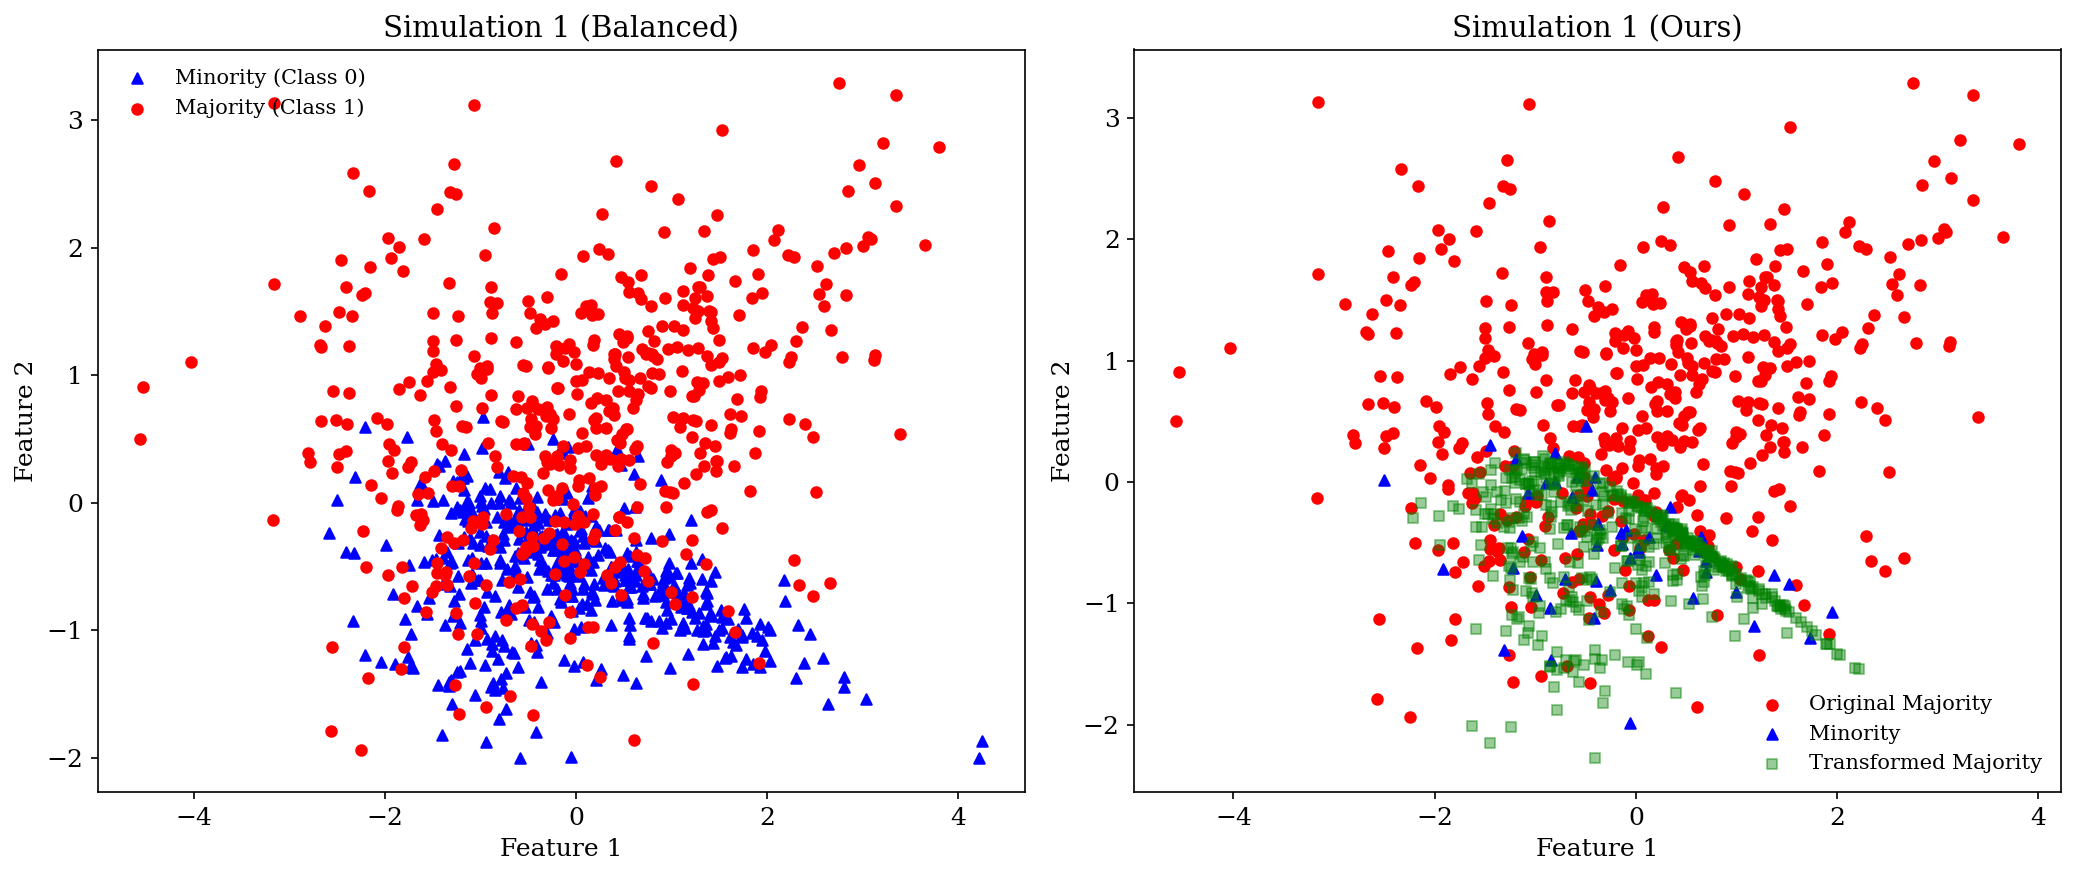


Running experiment for Simulation 2
n_minority: 50, n_majority: 500, n_trans: 450
[Epoch 500/1000] Total Loss: 0.0009   |   MMD Loss: 0.0000   |   Regularization Loss: 0.8788 (beta=0.001)
[Epoch 1000/1000] Total Loss: 0.0009   |   MMD Loss: 0.0000   |   Regularization Loss: 0.8774 (beta=0.001)


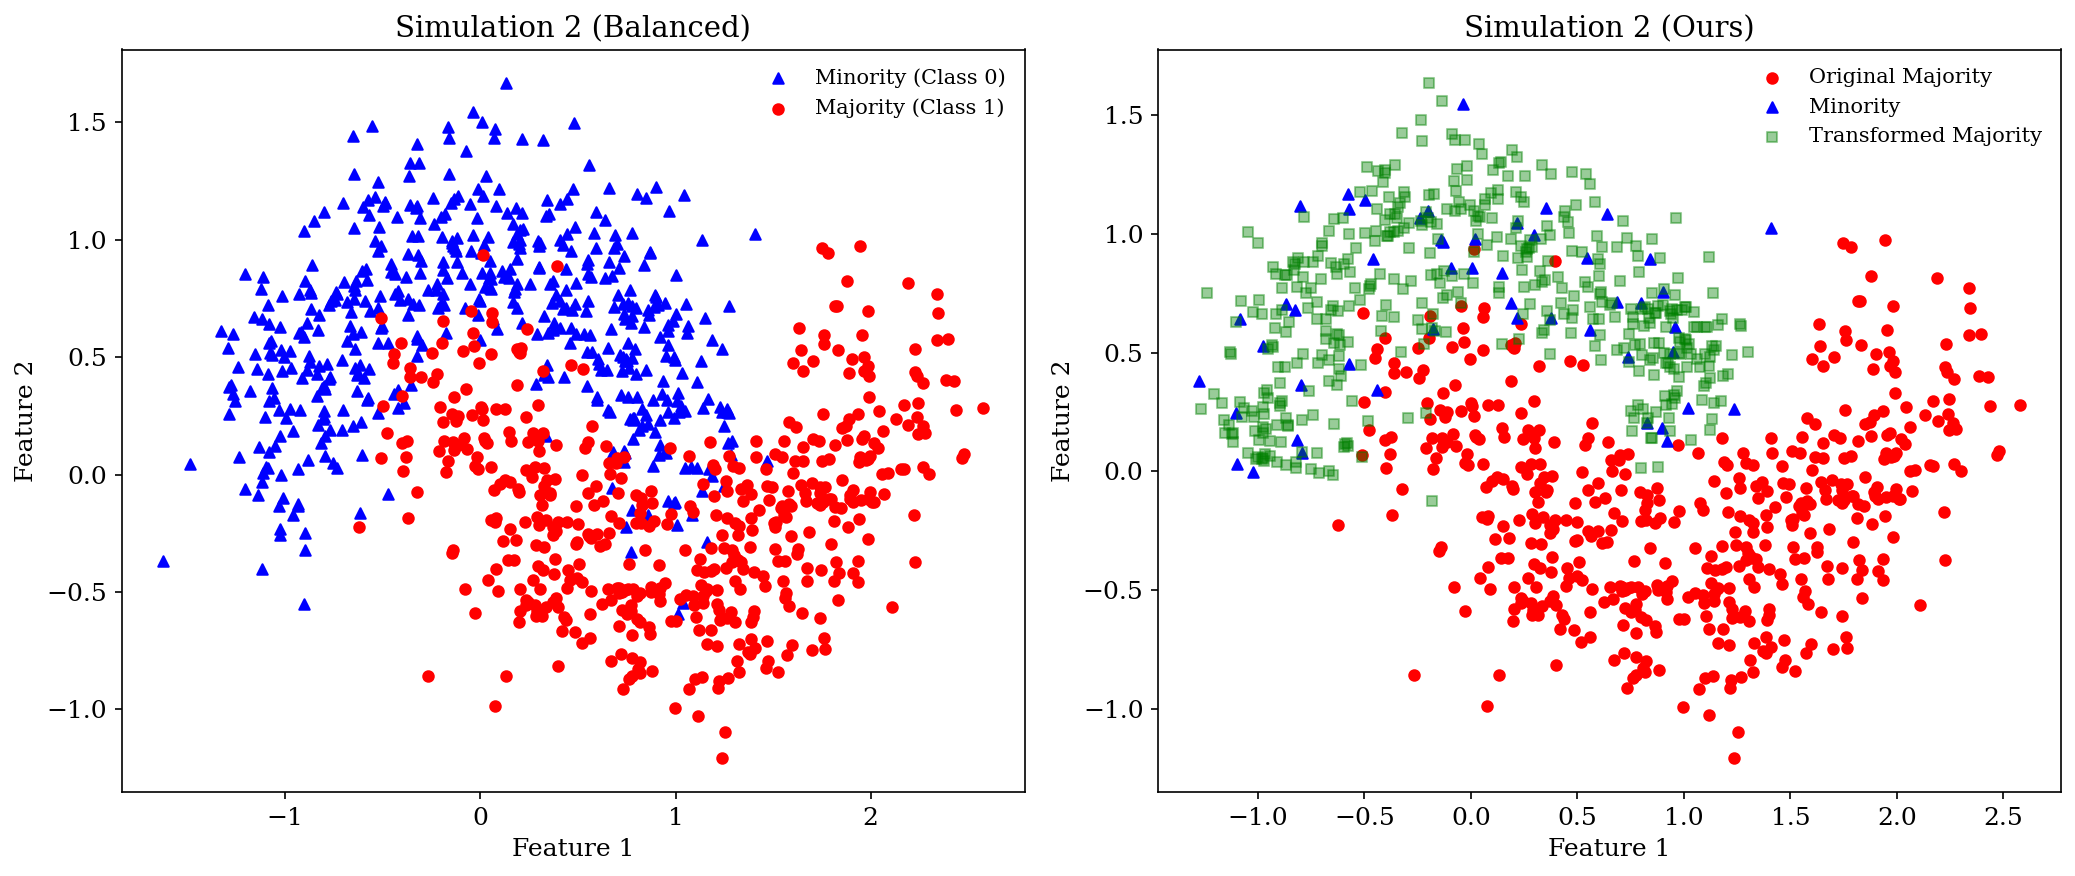


Running experiment for Simulation 3
n_minority: 50, n_majority: 500, n_trans: 450
[Epoch 500/1000] Total Loss: 0.0001   |   MMD Loss: 0.0000   |   Regularization Loss: 0.1203 (beta=0.001)
[Epoch 1000/1000] Total Loss: 0.0001   |   MMD Loss: 0.0000   |   Regularization Loss: 0.1195 (beta=0.001)


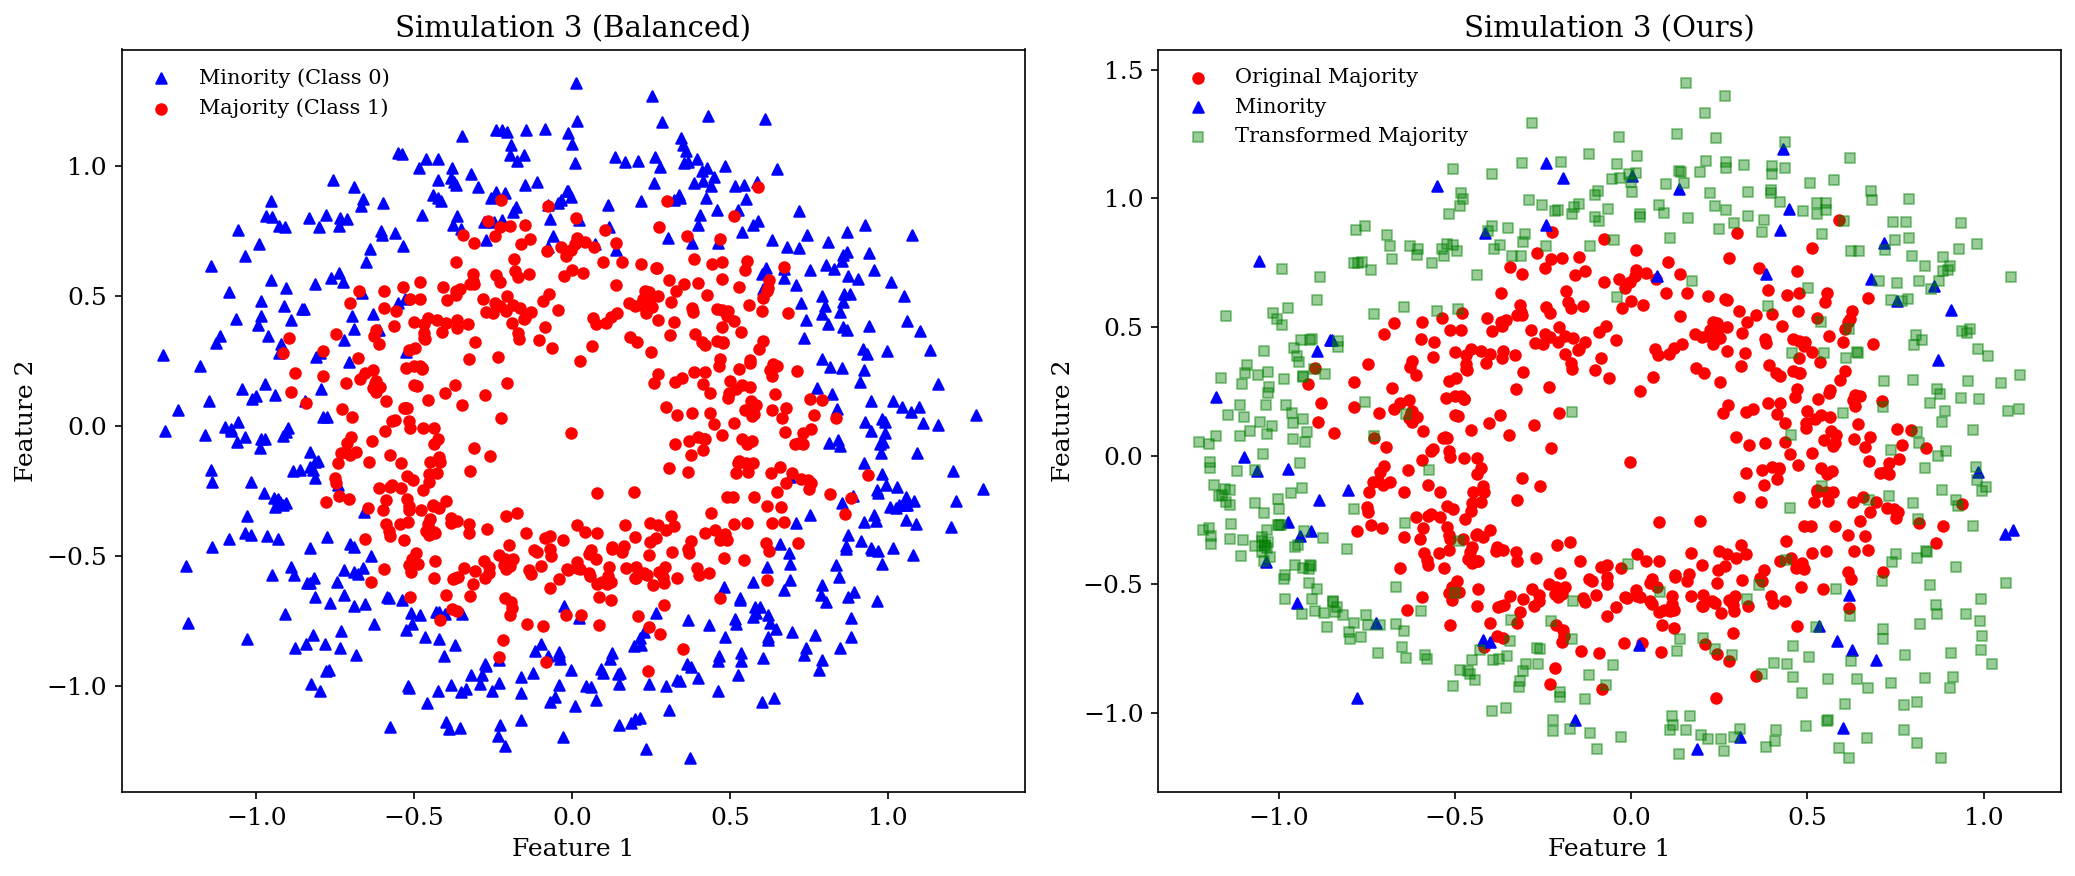

In [17]:
def main():
    set_random_seed(1203)
    
    # 1. make_classification 기반 데이터
    X_cls_bal, y_cls_bal = make_classification(n_samples=1000, n_features=2, n_informative=2, 
                                           n_redundant=0, n_clusters_per_class=2, 
                                           weights=[0.5, 0.5], flip_y=0.01, class_sep=0.6, random_state=seed)

    X_cls_imbl, y_cls_imbl = generate_imb_data(X_cls_bal, y_cls_bal, minor_y_cnt=50)
    run_experiment("Simulation 1", X_cls_bal, y_cls_bal, X_cls_imbl, y_cls_imbl)
    
    # 2. make_moons 기반 데이터
    X_moons_bal, y_moons_bal = make_moons(n_samples=1000, noise=0.25, random_state=1203)
    X_moons_imbl, y_moons_imbl = generate_imb_data(X_moons_bal, y_moons_bal, minor_y_cnt=50)
    run_experiment("Simulation 2", X_moons_bal, y_moons_bal, X_moons_imbl, y_moons_imbl)
    
    # 3. make_circles 기반 데이터
    X_circ_bal, y_circ_bal = make_circles(n_samples=1000, noise=0.15, factor=0.6, random_state=1203)
    X_circ_imbl, y_circ_imbl = generate_imb_data(X_circ_bal, y_circ_bal, minor_y_cnt=50)
    run_experiment("Simulation 3", X_circ_bal, y_circ_bal, X_circ_imbl, y_circ_imbl)

if __name__ == "__main__":
    main()